In [4]:
from PIL import Image
im = Image.open("00003/00003_930831_hl_a.ppm")
# 00002_930831_fa.ppm
# 00002_930831_fb.ppm
# 00002_930831_hl.ppm
# 00002_930831_hr.ppm
# 00002_930831_pr.ppm
# 00002_931230_fa.ppm
im.show()
im.thumbnail((224, 224), Image.ANTIALIAS)
im.show()

C:/Users/LiuCh/ml_project/00003


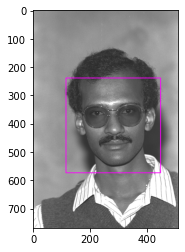

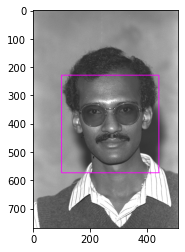

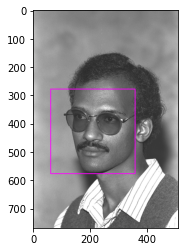

---Photo skipped---

---Photo skipped---



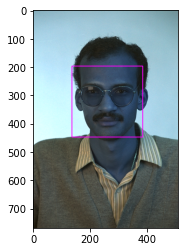

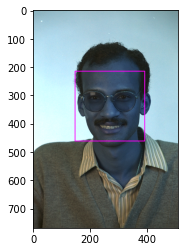

---Photo skipped---

---Photo skipped---

---Photo skipped---



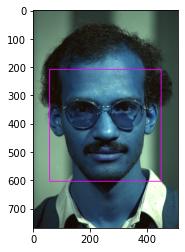

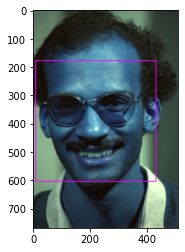

---Photo skipped---

---Photo skipped---



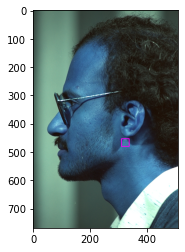

---Photo skipped---



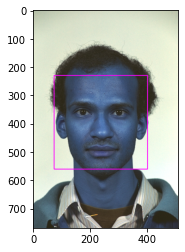

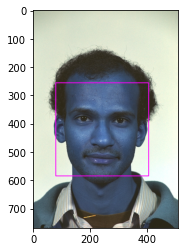

---Photo skipped---



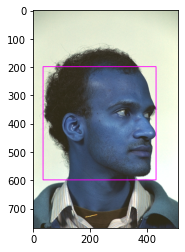

---Photo skipped---

---Photo skipped---



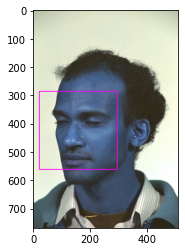

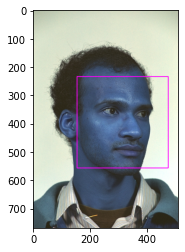

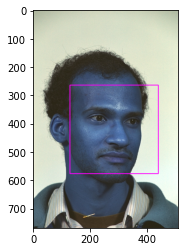

---Photo skipped---



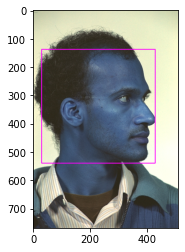

In [3]:
import cv2
import os
import pickle
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

headshots_folder_name = "C:/Users/LiuCh/ml_project/00003"

# dimension of images
image_width = 224
image_height = 224

# for detecting faces
facecascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# set the directory containing the images
images_dir = os.path.join(".", headshots_folder_name)
print(images_dir)

current_id = 0
label_ids = {}

# iterates through all the files in each subdirectories
for root, _, files in os.walk(images_dir):
    for file in files:
        # print(file)
        if file.endswith("ppm"):
            # path of the image
            path = os.path.join(root, file)

            # get the label name (name of the person)
        label = os.path.basename(root).replace(" ", ".").lower()

        # add the label (key) and its number (value)
        if not label in label_ids:
            label_ids[label] = current_id
            current_id += 1

        # load the image
        # print(path)
        imgtest = cv2.imread(path, cv2.IMREAD_COLOR)
        image_array = np.array(imgtest, "uint8")

        # get the faces detected in the image
        faces = facecascade.detectMultiScale(imgtest, scaleFactor=1.1, minNeighbors=5)

        # if not exactly 1 face is detected, skip this photo
        if len(faces) != 1:
            print(f'---Photo skipped---\n')
            # remove the original image
            os.remove(path)
            continue

        # save the detected face(s) and associate
        # them with the label
        for (x_, y_, w, h) in faces:

            # draw the face detected
            face_detect = cv2.rectangle(imgtest,
                    (x_, y_),
                    (x_+w, y_+h),
                    (255, 0, 255), 2)
            plt.imshow(face_detect)
            plt.show()

            # resize the detected face to 224x224
            size = (image_width, image_height)

            # detected face region
            roi = image_array[y_: y_ + h, x_: x_ + w]

            # resize the detected head to target size
            resized_image = cv2.resize(roi, size)
            image_array = np.array(resized_image, "uint8")

            # remove the original image
            os.remove(path)

            # replace the image with only the face
            im = Image.fromarray(image_array)
            im.save(path)

In [5]:
import os
import pandas as pd
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam


c:\Users\LiuCh\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_generator = \
    train_datagen.flow_from_directory(
'C:/Users/LiuCh/ml_project',
target_size=(224,224),
color_mode='rgb',
batch_size=32,
class_mode='categorical',
shuffle=True)


Found 64 images belonging to 3 classes.


In [12]:
from keras_vggface.vggface import VGGFace
from tensorflow.keras.layers import Layer, InputSpec

base_model = VGGFace(include_top=True,
    model='vgg16',
    input_shape=(224, 224, 3))
base_model.summary()

print(len(base_model.layers))
# 26 layers in the original VGG-Face


ModuleNotFoundError: No module named 'keras.engine.topology'